# DeepLearning method for credit card fraud detection.
* In this notebook, I will explore CNN and LSTM method for the fraud detection.

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2022-10-11 09:46:07.864624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# The following import and function call are the only additions to code required
# to automatically log metrics and parameters to MLflow.
import mlflow.keras

mlflow.keras.autolog()

/Users/michael/opt/anaconda3/envs/anomaly/lib/python3.9/site-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


In [3]:
# load file
filepath = "../Data/creditcard.csv"
df = pd.read_csv(filepath)

In [4]:
# identify X features, and y class
# Those data have been used froom creditCard notbook, EDA
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 43)

In [5]:
# balanced class with sklearn compute class weight
from sklearn.utils import compute_class_weight

cw = compute_class_weight(class_weight ="balanced", classes =np.unique(y_train), y = y_train)
#classweight = dict(zip(np.unique(y_train), cw))
classweight = {0:1, 1:100}

In [6]:
# Normalize data, scale to [0,1]
#train_data = StandardScaler().fit_transform(X_train)
#test_data = StandardScaler().fit_transform(X_test)
train_data = MinMaxScaler().fit_transform(X_train)
test_data = MinMaxScaler().fit_transform(X_test)
train_labels = y_train
test_labels = y_test

In [7]:
import pickle as pkl
processced_data = {'train_data':train_data,'test_data':test_data, 'train_labels':train_labels, 'test_labels':test_labels}

#to save it
with open("../Data/creditCard.pkl", "wb") as f:
    pkl.dump(processced_data, f)




In [8]:
#train_labels = train_labels.astype(bool)
#test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [9]:
print(train_labels.shape)
print(train_data.shape)
print(test_data.shape)

(213605,)
(213605, 30)
(71202, 30)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(([30,1]),input_shape=[30]),
    layers.Conv1D(64,kernel_size=1, padding='same', activation='relu'),
    layers.Conv1D(64,kernel_size=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=1),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    #layers.Dense(32, activation='relu'),
    
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    
    layers.Dense(1, activation="sigmoid"),
    ])


2022-10-11 09:46:16.895641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 30, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 30, 64)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 dense (Dense)               (None, 30, 64)            4160      
                                                        

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss=tf.keras.losses.BinaryCrossentropy(),#metrics=['binary_accuracy'])
    metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [13]:
import os
checkpoint_path = "../model/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [14]:
history = model.fit(train_data, train_labels, 
          epochs=30, 
        class_weight=classweight,
          batch_size=521,
          validation_data=(test_data, test_labels),
          shuffle=True, callbacks=[cp_callback])
          

2022/10/11 09:46:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a8d327e4d2ce4a4682e264fa2d75ac42', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
410/410 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.0000e+00 - precision: 0.7382 - recall: 0.3863
Epoch 1: saving model to ../model/training_1/cp.ckpt
410/410 [==============================] - 19s 44ms/step - loss: 0.3090 - accuracy: 0.0000e+00 - precision: 0.7382 - recall: 0.3863 - val_loss: 0.0113 - val_accuracy: 0.0000e+00 - val_precision: 0.8113 - val_recall: 0.6772
Epoch 2/30
409/410 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.0000e+00 - precision: 0.4767 - recall: 0.7562
Epoch 2: saving model to ../model/training_1/cp.ckpt
410/410 [==============================] - 20s 49ms/step - loss: 0.2205 - accuracy: 0.0000e+00 - precision: 0.4759 - recall: 0.7562 - val_loss: 0.0051 - val_accuracy: 0.0000e+00 - val_precision: 0.8370 - val_recall: 0.6063
Epoch 3/30
410/410 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.0000e+00 - precision: 0.4153 - recall: 0.8055
Epoch 3: saving model to ../model/tra

INFO:tensorflow:Assets written to: /var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/tmpwf2g66xk/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/tmpwf2g66xk/model/data/model/assets
/Users/michael/opt/anaconda3/envs/anomaly/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [15]:
model.save('../model/model_v12_conv1D.h5')

In [16]:
results = model.evaluate(X_test, y_test, batch_size=60)
print("test loss, test acc, precision, recall:", results)

1187/1187 [==============================] - 5s 4ms/step - loss: 89.0122 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00
test loss, test acc, precision, recall: [89.01223754882812, 0.998160183429718, 0.0, 0.0]


Dense layer training result


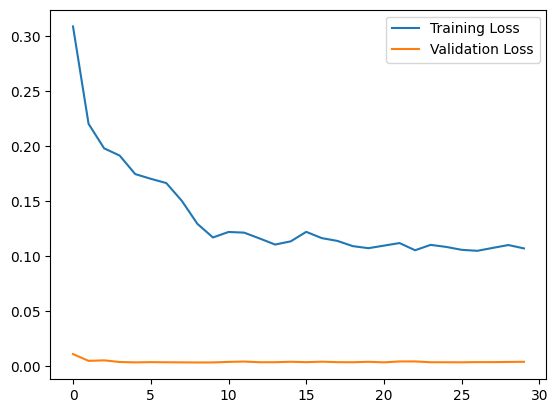

In [17]:
print('Dense layer training result')
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [18]:
preds = model.predict(test_data)
preds = (preds>0.05)
print("Deep learning Conv2D layer only confusion matrix")
tf.math.confusion_matrix(
    test_labels,
    preds,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

2226/2226 [==============================] - 8s 3ms/step
Deep learning Conv2D layer only confusion matrix


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[71044,    31],
       [   33,    94]], dtype=int32)>

In [19]:
m = test_labels.to_numpy()
p = preds.flatten()
c = np.logical_and(p, m)

In [26]:
from sklearn.metrics import confusion_matrix
from utils import *
confusion_matrix(m, p)

scores = stats('deepLearninig',p,m)
dl_scores_df = pd.DataFrame(scores)
other_score = pd.read_csv("../Data/MachineLearningSummary.csv")
df_all = pd.concat([other_score, dl_scores_df])
df_all.to_csv("../Data/MachineLearningSummary.csv")


Accuracy = 0.9991011488441336
Precision = 0.752
Recall = 0.7401574803149606


In [31]:
df_all.head(7)

,Unnamed: 0.1,Unnamed: 0,model,accuracy,precision,recall,f1_score,ROC
0,0.0,0.0,"LogisticRegression(class_weight='balanced', ma...",0.977704,0.070796,0.905660,0.131327,0.638492
1,1.0,1.0,"SVC(class_weight={0: 1, 1: 100})",0.998420,0.556338,0.745283,0.637097,0.500053
2,2.0,2.0,SVC(class_weight='balanced'),0.996840,0.341880,0.754717,0.470588,0.500053
3,3.0,3.0,RandomForestClassifier(class_weight='balanced'...,0.999421,0.929412,0.745283,0.827225,NaN
4,4.0,4.0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.999491,0.942529,0.773585,0.849741,NaN
5,0.0,NaN,autoencoder,0.167234,0.001600,0.760000,0.003194,141.000000
0,NaN,NaN,deepLearninig,0.999101,0.752000,0.740157,0.746032,NaN


In [27]:
# display all true value's index
[i for i, x in enumerate(p) if x]

[118,
 934,
 2034,
 2109,
 2218,
 3274,
 6664,
 6741,
 6804,
 7261,
 7551,
 7552,
 7694,
 7837,
 7941,
 8033,
 8791,
 9206,
 9512,
 9560,
 9869,
 10415,
 10469,
 10964,
 11411,
 11640,
 11699,
 12361,
 12548,
 12705,
 13984,
 14211,
 14559,
 14702,
 15328,
 15337,
 15355,
 15764,
 16165,
 18539,
 18753,
 19022,
 20244,
 20331,
 20526,
 21098,
 23020,
 25156,
 25231,
 25324,
 25732,
 26437,
 27161,
 27587,
 27728,
 27850,
 27880,
 28205,
 29067,
 30780,
 31439,
 31903,
 32117,
 32201,
 32291,
 34023,
 34122,
 34193,
 34503,
 35052,
 37802,
 38001,
 38054,
 38229,
 39327,
 40887,
 40962,
 42411,
 43038,
 43842,
 44491,
 45369,
 45607,
 46543,
 46868,
 47336,
 47544,
 47757,
 48599,
 50196,
 50417,
 50434,
 51020,
 52241,
 54026,
 54124,
 54143,
 54858,
 55527,
 56033,
 56216,
 56534,
 57533,
 57702,
 58304,
 58341,
 58576,
 59361,
 59955,
 60751,
 60794,
 61888,
 62004,
 62157,
 62914,
 63230,
 63371,
 63849,
 63942,
 65899,
 67146,
 69121,
 69577,
 69810,
 71130]

In [28]:
#new = tf.keras.models.load_model('../model/model_v1.h5')
#new.summary()

train_true = [i for i, x in enumerate(train_labels) if x]

test_true = [i for i, x in enumerate(test_labels) if x]

print("True in train and test labels", len(train_true)/len(train_labels), len(test_true)/len(test_labels))

True in train and test labels 0.0017087614990285809 0.0017836577624224038
